# Beamforming for location

We now calculate the beamforming. This consists of calculating waveform features first (envelopes, kurtosis, etc.) and to shift-and-stack them according to the points in the 3D source-search grid previously calculated.

In [1]:
import beampower as bp
import glob
import obspy
import os
import numpy as np
import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import hilbert, find_peaks
from scipy.stats import median_abs_deviation

beamnetresponse GPU library is not compiled! Build the GPU library first in order to use the GPU routines.


In [2]:
%load_ext autoreload
%autoreload 2

## Get data metadata

In [3]:
DIRPATH_WAVEFORMS = "../data/processed/"
filepaths_waveforms = glob.glob(os.path.join(DIRPATH_WAVEFORMS, "*.mseed"))

# Get sampling rate
header = obspy.read(filepaths_waveforms[0], headonly=True)
sampling_rate = header[0].stats.sampling_rate

## Read travel times

Convert the travel times into int32 indexes.

In [4]:
FILEPATH_TRAVELTIMES = "../data/travel_times.nc"
travel_times = xr.load_dataset(FILEPATH_TRAVELTIMES)

# Turn to moveouts in samples
for phase in travel_times.var():
   tt = travel_times[phase]
   travel_times[phase] = np.round(sampling_rate * tt).astype(np.int32)

travel_times

<xarray.Dataset>
Dimensions:    (depth: 120, latitude: 40, longitude: 50, station: 8)
Coordinates:
  * depth      (depth) float64 -2.0 -1.731 -1.462 -1.193 ... 29.46 29.73 30.0
  * longitude  (longitude) float64 30.2 30.21 30.21 30.22 ... 30.44 30.44 30.45
  * latitude   (latitude) float64 40.6 40.6 40.61 40.61 ... 40.75 40.76 40.76
  * station    (station) object 'DC06' 'DC07' 'DC08' ... 'DE08' 'SAUV' 'SPNC'
Data variables:
    p          (depth, latitude, longitude, station) int32 102 78 43 ... 145 138
    s          (depth, latitude, longitude, station) int32 177 134 ... 251 239

## Calculate waveform features

In [5]:
CHANNELS = ["N", "E", "Z"]
STATIONS = list(travel_times.station.data)
NPTS = header[0].stats.npts

# Initialize features array
features = np.zeros((len(STATIONS), len(CHANNELS), NPTS), dtype=np.float32)

# Calculate
for filepath in tqdm.tqdm(filepaths_waveforms):

    # Read trace
    stream = obspy.read(filepath)
    station = stream[0].stats.station
    channel = stream[0].stats.channel
    data = stream[0].data

    # Get coordinate
    station_id = STATIONS.index(station)
    channel_id = CHANNELS.index(channel[-1])

    # Calculate features
    feature_norm = median_abs_deviation(data)
    feature_norm = 1.0 if feature_norm == 0.0 else feature_norm

    # Envelope
    feature = np.abs(hilbert(data / feature_norm)).astype(np.float32)
    features[station_id, channel_id] = feature.clip(
        np.min(feature),
        10.0 ** (5.0 * median_abs_deviation(feature)),
    )


100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


## Show an example envelope

(-24.727569389343262, 24.727569389343262)

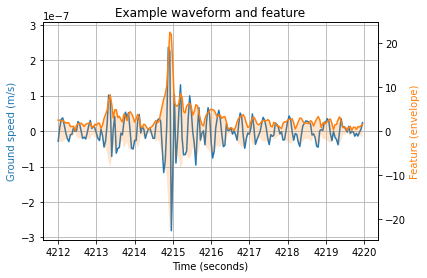

In [6]:
START, END = 105300, 105500

# Get first waveform
stream = obspy.read(filepaths_waveforms[0])
station = stream[0].stats.station
channel = stream[0].stats.channel
data = stream[0].data[START:END]
times = stream[0].times()[START:END]

# Get coordinate
station_id = STATIONS.index(station)
channel_id = CHANNELS.index(channel[-1])

# Plot
fig, ax = plt.subplots()
ax.plot(times, data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_xlabel("Time (seconds)")
ax.set_title("Example waveform and feature")
ax.grid()

# Envelope on a second axe (not the same scale)
axf = ax.twinx()
feature = features[station_id, channel_id, START:END]
axf.plot(times, feature, "C1")
axf.fill_between(times, -feature, feature, fc="C1", alpha=0.2)
axf.set_ylabel("Feature (envelope)", color="C1")
ymax = max(np.abs(axf.get_ylim()))
axf.set_ylim(-ymax, ymax)


## Source and phase weights

In [8]:
# Get time delays
time_delays = travel_times.to_array().to_numpy().astype(np.int32)
time_delays = time_delays.reshape((*time_delays.shape[:2], -1))
time_delays = time_delays.transpose(-1, 1, 0)

weight_shape = (*features.shape[:-1], len(travel_times.var()))
weights_phase = np.ones(weight_shape, dtype=np.float32)
weights_phase[:, :2, 0] = 0.0
weights_phase[:, 2, 1] = 0.0
weights_sources = np.ones(time_delays.shape[:-1], dtype=np.float32)

# Beamform
response, source_id = bp.beampower.beamform_max(
    features,
    time_delays,
    weights_phase,
    weights_sources,
    device="cpu"
)

## Detect

In [9]:
MIN_INTERVAL = int(20 * sampling_rate)
MADMED_RATIO = 15

# Temporal
window_length = int(1800 * sampling_rate)
window_step = int((3 * window_length) // 4)
calendar_times = stream[0].times()
calendar_times_slider = calendar_times[::window_step][:-1]

# Threshold
response_slider = sliding_window_view(response, window_length)
response_slider = response_slider[::window_step]
response_median = np.median(response_slider, axis=-1)
response_mad = median_abs_deviation(response_slider, axis=-1)
threshold = response_median + MADMED_RATIO * response_mad

# Interpolation
threshold = np.interp(calendar_times, calendar_times_slider, threshold)

# Detection
peaks = find_peaks(response, distance=MIN_INTERVAL, height=threshold)

In [10]:
WAVEFORM_ID = 10

# The surface extents are in degrees, the depth positive downwards and in km
WEST, EAST, SOUTH, NORTH, DOWN, UP = 30.20, 30.45, 40.60, 40.76, 30.0, -2.0
GRID_SIZE = N_DEPTH, N_LAT, N_LON = 50, 20, 30

# Interpolate
depths = np.linspace(UP, DOWN, N_DEPTH)
longitudes = np.linspace(WEST, EAST, N_LON)
latitudes = np.linspace(SOUTH, NORTH, N_LAT)

grid = np.meshgrid(longitudes, latitudes, depths, indexing="ij")
coordinates = np.array([coordinate.ravel() for coordinate in grid])

source_id_sel = source_id[peaks[0][WAVEFORM_ID]]
source_coordinates = [coordinate[source_id_sel] for coordinate in coordinates]

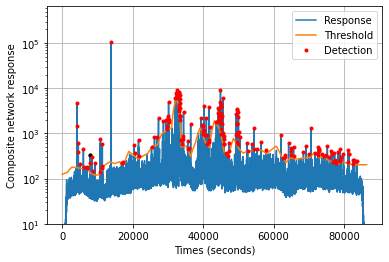

Text(0.5, 0, 'Local time (seconds)')

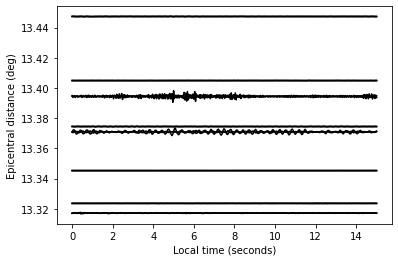

In [11]:
WINDOW_VIEW_EXTENT_SEC = 5

# Show composite response versus time
plt.plot(calendar_times, response, rasterized=True)
plt.plot(calendar_times, threshold, rasterized=True)
for index, (peak_id, peak_height) in enumerate(
    zip(peaks[0], peaks[1]["peak_heights"])
):
    plt.plot(calendar_times[peak_id], peak_height, "r.")
    if index == WAVEFORM_ID:
        plt.plot(calendar_times[peak_id], peak_height, "k.")

# Labels
plt.legend(["Response", "Threshold", "Detection"])
plt.xlabel("Times (seconds)")
plt.ylabel("Composite network response")
plt.yscale("log")
plt.ylim(bottom=10)
plt.grid()
plt.show()

fig, ax = plt.subplots(1)
for trace in obspy.read(os.path.join(DIRPATH_WAVEFORMS, "*.mseed")):

    date = calendar_times[peaks[0][WAVEFORM_ID]]
    date = trace.stats.starttime + date
    
    trace.trim(
        starttime=date - WINDOW_VIEW_EXTENT_SEC,
        endtime=date + 2 * WINDOW_VIEW_EXTENT_SEC,
    )

    # Attach response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_WAVEFORMS, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    station_coordinates = inventory.get_coordinates(trace.id)

    # Distance
    p1 = station_coordinates["latitude"], station_coordinates["longitude"]
    p2 = source_coordinates[0], source_coordinates[1]
    distance = obspy.geodetics.base.locations2degrees(*p1, *p2)

    # Plot
    ax.plot(trace.times(), 400 * trace.data + distance, "k", rasterized=True)

ax.set_ylabel("Epicentral distance (deg)")
ax.set_xlabel("Local time (seconds)")

# WORK TO DO FOR REPRESENTATION
